# Extension of the Paper


## Title : Predicting covid cases with Google Trends

### Abstract
Since January 2020, the covid-19 pandemic has challenged the various hospital systems. The response to this health crisis has often been a lockdown, causing an economic and social crisis. This response is in reaction rather than in preparation and anticipation.

Since the situation evolves every week, it's interesting to have an accurate short term forecast in order to better anticipate the next outbreak and develop a better strategy to contain the virus and thus limit the economic and social impact. This study proposes to extend the method used in the paper “Predicting the present with Google trends” to develop a short term forecast of the number of Covid-19 cases in France. Then, improving this prediction using appropriate and relevant Google Trends data. For example, by including indexes of topics related to health at the level of research on the symptoms of Covid, or by using indexes related to social life and which could indicate an increase in trips and gatherings over a given period.

### Research Questions

1.  What topics are mostly related to the evolution of the number of deaths in France?
    
2.  Does including the indexes related to health (symptoms, cough...) to our model improve our forecast?
    
3.  Given the many restrictions around social life applied during this pandemic, it is interesting to wonder if including Google trends indices related to social life such as dining out in the summer period of 2020, could improve the prediction?
    
4.  Can Google Trends Data help to predict noisy data as Covid deaths?
    

### Proposed dataset
 
1. **Official numbers of covid cases**
The [dataset](https://opendata.ecdc.europa.eu/covid19/casedistribution/csv) can be found on the EU open data portal. The dataset provides daily cases and deaths per country. We can therefore easily extract the daily cases for France.

2. Google trends indexes related to covid
Data can be downloaded as CSV files containing a timestamp and the corresponding index using [Google Trends](https://trends.google.com/trends/?geo=US).

For example : [Symptomes covid](https://trends.google.fr/trends/explore?q=symptomes%20covid&geo=FR) and [restaurant](https://trends.google.fr/trends/explore?geo=FR&q=Top%2010%20restaurant) indexes.


### Methods
    

- 1. Data collection and pre-processing
	- 1.1 Collect of Covid-19 related data
	- 1.2 Pre-processing of Covid-19 related data
	- 1.3 Google Trends data (Create categories with associated key words)
		- 1.3.1 Categories with 10 key-words
		- 1.3.2 Extract google trends indexes

- 2. Cross-Correlation

- 3. Apply the method of the paper
	- 3.1 In sample predicition using AR-1
	- 3.2 Out-of-sample prediction

- 4. Conclusion

- 5. Going Further

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Install pytrends to use Google Trends API
!pip install pytrends

In [11]:
# Imports
import os
import sys
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Start and end time for the analysis

START = '2019-12-31'
END = '2020-12-06'

## 1. Data collection and pre-processing

### 1.1 Collect of Covid-19 related data

In [13]:
def download_csv(csv_url, output_dir):
    """ Download a csv file from a link and save it.
    
        Args:
            - csv_url        url of the csv file to download
            - output_dir     output path to save the downloaded file
    """
    
    # request the csv file on the internet
    req = requests.get(csv_url)
    url_content = req.content
    
    # write it on the computer
    csv_file = open(output_dir, 'wb')
    csv_file.write(url_content)
    csv_file.close()

In [18]:
# Download covid cases data worldwide
csv_url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
output_file = 'covid_cases.csv'
download_csv(csv_url, output_file)

In [37]:
# Load raw data
raw_data = pd.read_csv('covid_cases.csv')

### 1.2 Pre-processing of Covid-19 related data

In [98]:
# Select France data
raw_data_fr = raw_data[raw_data['countriesAndTerritories'] == 'France']

# Rename columns
data_fr = raw_data_fr[['dateRep', 'deaths']]
data_fr = data_fr.rename(columns={'dateRep': 'date'})

# Set datetime
data_fr['date'] = pd.to_datetime(data_fr['date'], format = '%d/%m/%Y')
data_fr = data_fr.set_index(data_fr["date"])
data_fr = data_fr.drop(['date'],axis=1)

# Select timeframe
data_fr = data_fr[END:START]
data_fr.head()

,deaths
date,
2020-12-06,214
2020-12-05,627
2020-12-04,324
2020-12-03,310
2020-12-02,775


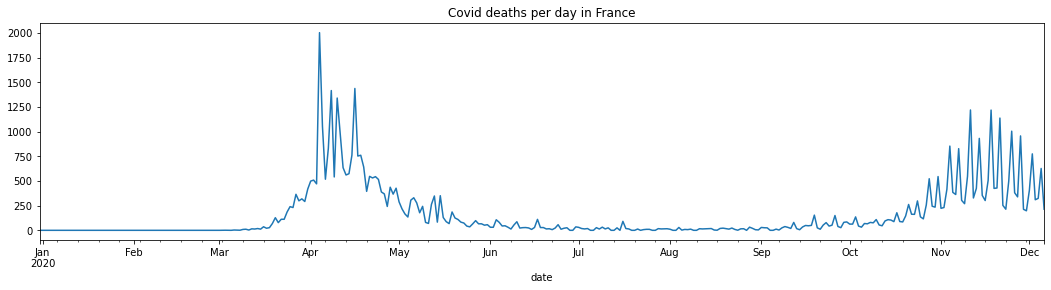

In [45]:
figure = data_fr['deaths'].plot(title = 'Covid deaths per day in France',figsize=(18,4))

In [46]:
# Aggregate data per week
aggregated_data_fr = data_fr.resample('W').sum()

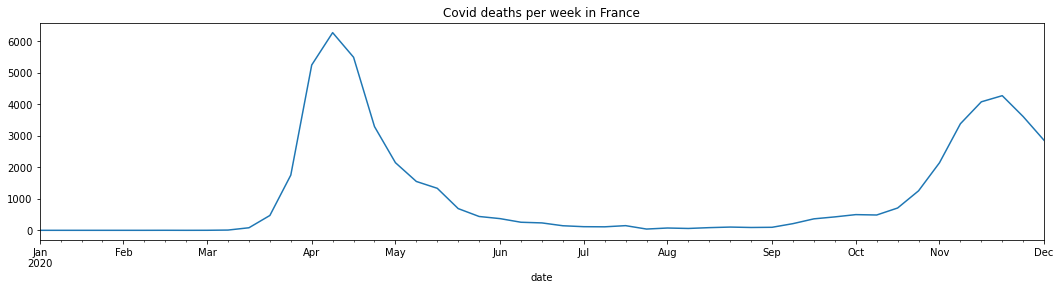

In [47]:
# plot the number of deaths aggregated per week
figure = aggregated_data_fr['deaths'].plot(title = 'Covid deaths per week in France',figsize=(18,4))

### 1.3 Google Trends data (Create categories with associated key words)
The purpose of this project is to try to use Google Trends to help predict the covid deaths. We propose to focus our study on different categories of requests :
- **symptoms** : google key words related to covid symptoms as cough, fever, lose of taste etc ...
- **social** : google key words related to social activities as top restaurant, blablacar or plato boardgame ...
- **how to** : google requests of the top 10 how to questions in 2020 related to different fields.

In this section, we perform the following steps :
 1. Define 10 key-words per category that we want to analyse in order to predict the covid deaths
 2. We use the [pytrends](https://github.com/GeneralMills/pytrends) tool to extract the google trends indexes for the desired timeframe (from `2019-12-31` to `2020-12-04`)
 3. We plot the google indexes.
 
 
#### 1.3.1 Categories with 10 key-words

In [99]:

# key_words dictionary
key_words = {}

# requests related to major covid symptoms
key_words['symptoms'] = ['fievre',
                        'toux seche',
                        'fatigue',
                        'courbatures',
                        'maux de gorge',
                        'diarrhee',
                        'maux de tete',
                        'perte du gout',
                        'perte odorat',
                        'essoufflement']

# requests related to social life
key_words['social'] = ['blablacar',
                       'taxi',
                       'house party',
                       'Uber',
                       'top cafe',
                       'top bar',
                       'plato',
                       'top restaurant',
                       'Comparateur vol',
                       'Couvre-feu']

# Top 10 requests about the how to questions in 2020
key_words['howto'] = ['Comment faire un masque',
                    'Comment savoir si on a le coronavirus',
                    'Comment mettre un masque',
                    'Comment calculer son IMC',
                    'Comment faire du pain',
                    'Comment calculer distance 100 km',
                    'Comment faire un masque sans machine à coudre',
                    'Comment se transmet le coronavirus',
                    'Comment fabriquer un gel hydroalcoolique',
                    'Comment mettre un masque chirurgical']

#### 1.3.2 Extract google trends indexes

In [49]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='fr-FR', tz=360)

def get_trends(kw_list, timeframe, country):
    """ Return google trends for specific key words in a geographic area for a specific timeframe
        
        Args:
            - kw_list      requests or key words
            - timeframe    format 'YYYY-MM-DD YYYY-MM-DD'
            - country      geographic code
        
        Returns:
            - trends_df    dataframe with interests over time for each keyword
    """
    trends_df = pd.DataFrame()
    for key_word in kw_list:
        # request the trends data of a specific "key_word"
        pytrends.build_payload([key_word], cat=0, timeframe=timeframe, geo=country, gprop='')
        trends = pytrends.interest_over_time()
        
        # write the requested data in a dataframe
        trends_df[key_word] = trends[key_word]
        
    return trends_df

In [50]:
# Define parameters
country = 'FR'
timeframe = ' '.join([START, END])

In [51]:
# get the data of each of the keywords stored in the dictionary "key_words"
trends_data = get_trends([key_word for key, list_key_words in key_words.items() for key_word in list_key_words ], timeframe, country)

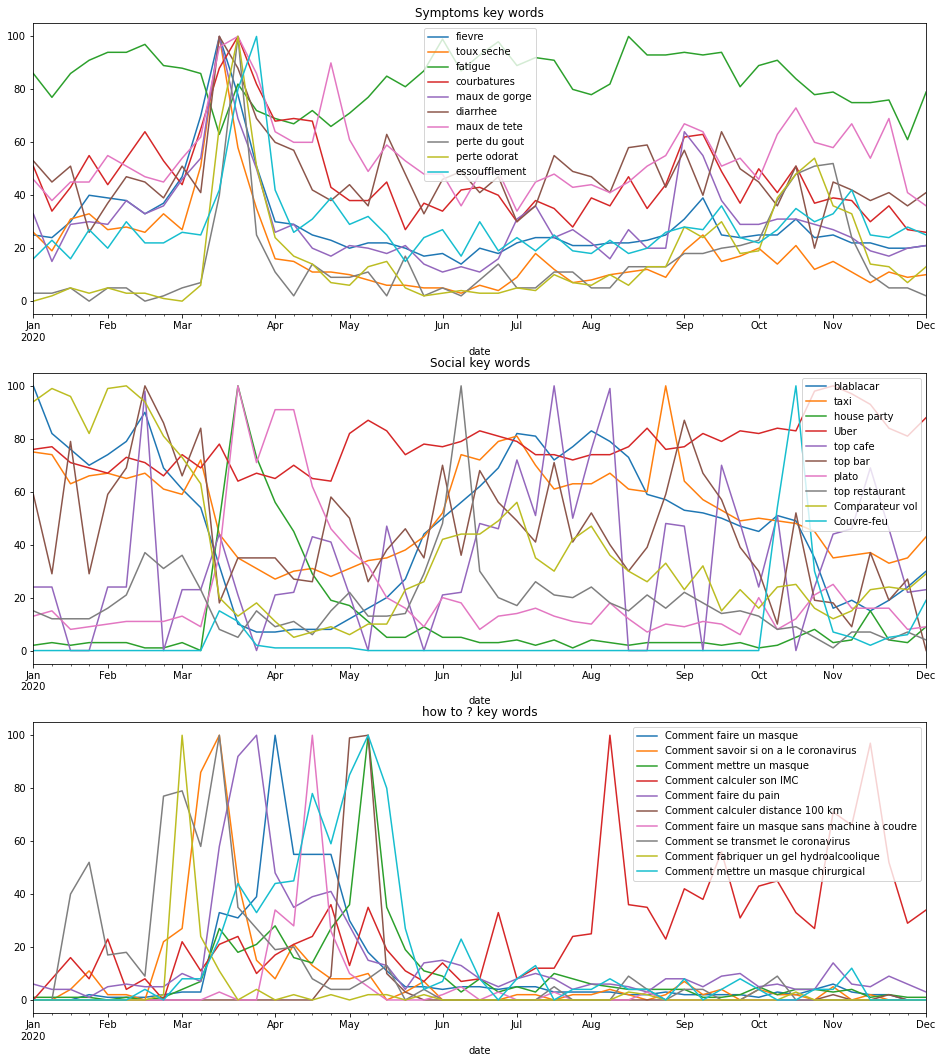

In [97]:
keys_titles = [('symptoms', 'Symptoms key words'), ('social', 'Social key words'), ('howto', 'how to ? key words')]

# Plot the the Google Trends data as function of the time and the selected keywords per category
fig, axs = plt.subplots(3)
fig.subplots_adjust(top=1.5)

for ax, (key, title) in zip(axs, keys_titles):
    trends_data[key_words[key]].plot(title = title, ax=ax, figsize=(16,10))

## 2. Cross-Correlation
In this section, we perform a cross-correlation analysis between each key-word signal and the covid deaths signal. We vizualize the results per category in order to show the most significant key word in a given category.
After the analysis of the correlations of the key-words for each category, we provide a discussion about the results.

In [92]:
def cross_correlation(base_signal, signals, method = 'spearman'):
    """ Compute cross correlation between the base and trends signals.
    
        Args:
            - base_signal      Pandas Series 
            - signals          Pandas DataFrame
            - method           type of cross correlation
    
        Returns:
            - Pandas Series of the absolute value of the cross correlation between trends and base signal 
    """
    corr = pd.Series(dtype=np.float64)
    for key_word in signals:
        # compute the correlation between the signal we want to predict (deaths) with the google trends data for each key_word
        corr[key_word] = signals[key_word].corr(base_signal, method = method)
        
    # return the absolute value of the correlation     
    return corr.abs().sort_values()


def plot_correlation(correlations):
    """ Build the different plots of the correlations for each category
    
        Args:
            - correlations      list of Pandas Series
    """
    fig, axs = plt.subplots(len(correlations), figsize=(7,22))

    for ax, (key, corr) in zip(axs, correlations):
        ax.hlines(corr.index, xmin=0, xmax=corr.values)
        ax.plot(corr.values, corr.index, "o", color='black')
        ax.set_xlim(0, 1.)
        ax.set_xlabel('| Correlation |')
        ax.set_ylabel('Google Trend Request')
        #ax.yaxis.set_label_position("right")
        #ax.yaxis.tick_right()
        ax.set_title(f"Correlation of Google trends request with covid deaths of the category: {key}")
    plt.show()

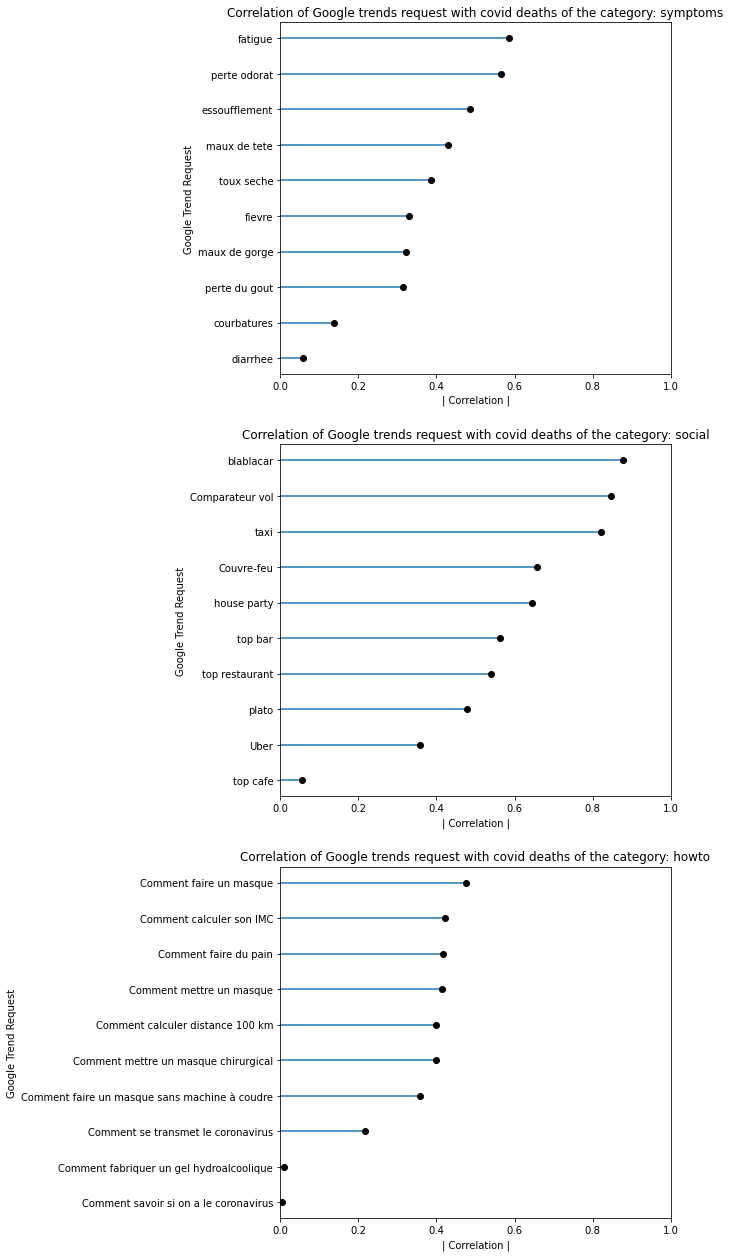

In [93]:
deaths = aggregated_data_fr['deaths']
plot_correlation([(key, cross_correlation(deaths, trends_data[values])) for key, values in key_words.items()])

#### Results : 

- **symptoms** : The most specific symptoms of COVID 19 are the most correlated to the death data. This is an expected result since because the more the virus evolves, the more people tend to learn about the symptoms.
- **social** : In general, the social keywords tends to have a high correlation compared to the 2 other categories. 
This is interesting in the sense that we see that social phenomena have a strong relationship with the evolution of the virus. With more extensive use of this data, governments could put in place much more targeted measures and be less in the reaction.
- **howto** : The same conclusions can be drawn for this category. It follows the evolution of the spread of the virus.

## 3 Apply the method of the paper

### 3.1 In sample predicition using AR-1

As in the paper, the first step is to fit our model on the entire dataset. The idea is to have an insight on the significant features for the prediction model. 
- **metric** : The metric used is a statistical test on the p-value, where a p-value less than the significant value of **0.05** means that there's no significant relation between the feature and the deaths data.

- **results**: This procedure is applied to the 3 different categories and the results for the most interesting requests per category by an appropriate visualization.

In [55]:
import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import meanabs

In [85]:
def compute_p(endog, exog, lags=[1,2]):
    """ Build the trend model over all the dataset to compare the p values
    
        Args:
            - endog       Pandas Series representing the index we are trying to predict (deaths)
            - exog        Pandas DataFrame representing the external Google Trends data

        Returns:
            - Pandas Series p-values for each Google Trends features sorted
    """
    
    # Create the trends in sample model to observe the p-value with respect to each features used
    trend_model = AutoReg(endog, lags = lags, exog = exog).fit()
    
    # len(trend_model.ar_lags)+1 is used to get rid of the intercept and coefficient related to the AR model
    return trend_model.pvalues[len(trend_model.ar_lags)+1:].sort_values(ascending = False)


def plot_Pz(Pzs):
    """ Build the different plots of the p-values for each category
    
        Args:
            - Pzs      list of Pandas Series
    """
    
    fig, axs = plt.subplots(len(Pzs), figsize=(7,22))

    for ax, (key, p_value) in zip(axs, Pzs):
        ax.hlines(p_value.index, xmin=0, xmax=p_value.values)
        ax.plot(p_value.values, p_value.index, "o", color='black')
        ax.axvline(x=0.05, color='black')
        ax.set_xlim(0, 1.)
        ax.set_xlabel('P>|z|')
        ax.set_ylabel('Google Trend Request')
        ax.set_title(f"P>|z| of Google trends request with covid deaths of the category: {key}")
        
    plt.show()

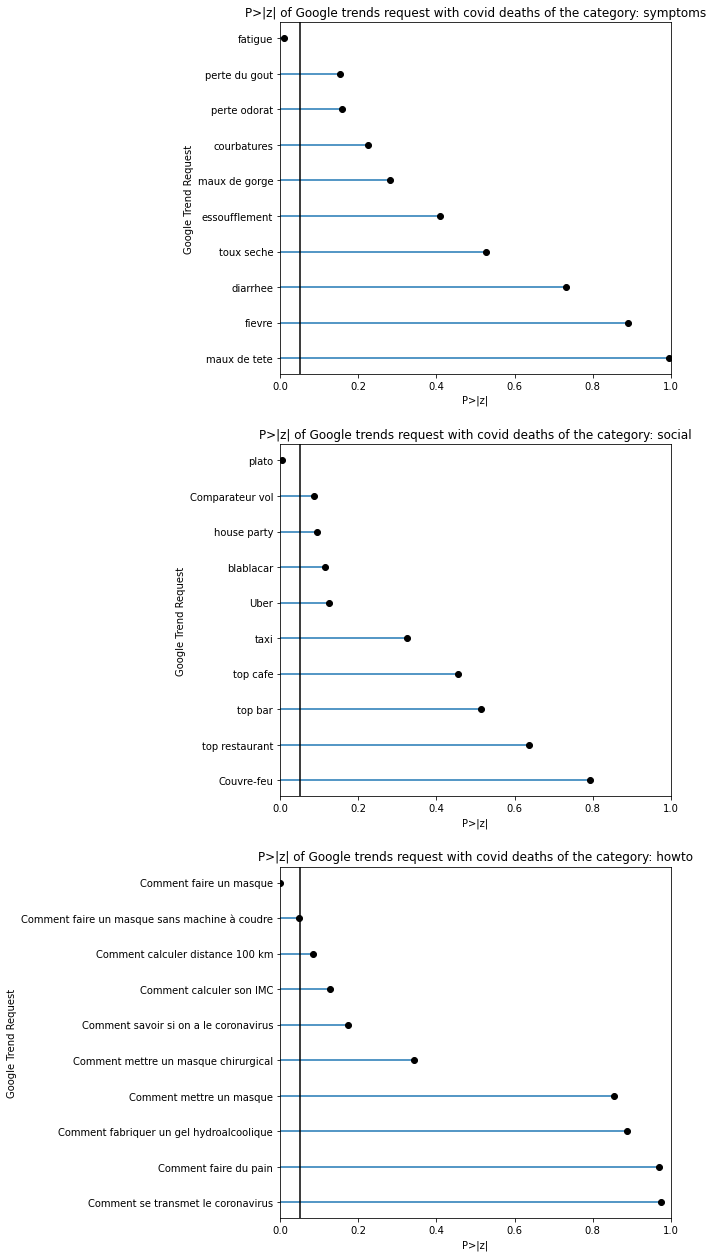

In [86]:
# Compute and plot all the p-values of each features with respect to each category
plot_Pz([(key, compute_p(aggregated_data_fr["deaths"], trends_data[values], lags=[1,2])) for key, values in key_words.items()])

#### Results : 

Let's analyze the results for each category : 

- **symptoms** : We notice that 3 requests are significantely linked to the COVID deaths : Diarrhee, loss of smell and loss of taste. This is interesting since the queries related to the most recognizable COVID symptoms tend to have a smaller p-values than the other. This allows to confirm the conclusions of the correlation chapter. However, the diarhee keyword seems like an outlier, but looking at its time series, it seems that it follows the same evolution as the death data.
- **social** : This time, the results are unexpected. The p value tends to be smaller for the requests related to blablacar, uber and flights comparator. These requests are negatively correlated to the evolution of death. But none of the requests have a significant effect on the death data, which is quiete surprising. We would expect a stronger statistical relation.
- **howto** : Finally, the how to indicators are quiete interesting. We observe that the most significant requests are the one related to how to design a home mask for example, or how to calculate the IMC. Those requests are totally related to the COVID situation and especially to the lockdown situation.

### 3.2 Out-of-sample prediction

Let's explore the one step ahead forecast using an AR-1 model. The data are split into a train set, which stops at the day before the prediction, and a test set which is the actual prediction. The goal of this part is to explore the performance of Google Trends data in improving the prediction of the second wave of COVID-19 .The MAE is computed between the base model and the trend model. The idea here is to observe the effect of each request on the MAE and look for improvements. Thus, a trends model is computed for each request. The resulting improvement (or deterioration) of the MAE is then plotted and some conclusions are made.

In [87]:
from sklearn.metrics import mean_absolute_error


def MAE_AR(endog, exog, date="2020-08-01"):
    """ Compute the MAE improvement in out of sample prediction between 
        the base and trends model for each features of each category. 
        The trends model contains only one Google Trends data key word.
    
        Args: 
            - endog          Pandas Series representing the index we are trying to predict (deaths)
            - exog           Pandas DataFrame representing the external Google Trends data
            - date           Date where the prediction starts
            
        Returns:
            - perf           Pandas DataFrame representing the MAE improvement of each features
    
    """
    
    n_obs = len(endog)
    
    # Build the prediction DataFrame
    prediction = pd.DataFrame()
    prediction["date"] = endog.index
    prediction["date"] = pd.to_datetime(prediction["date"])
    prediction = prediction.set_index("date")
    prediction["actual"] = endog.values
    
    # Get the number of datapoint before the first prediction
    n_init_training = len(prediction[prediction.index < date])
    improvement = {}
    
    # loop over all the features
    for column in exog.columns:
        
        prediction["base"] = np.nan
        prediction["trend"] = np.nan
        
        # For each prediction, re-train the model on the data precending the time of the current prediction
        for i in range(n_init_training, n_obs):
            
            # Apply out-of-sample forecast for the base model
            base_model = AutoReg(endog[:i], lags = [1,2],old_names = False, trend = 'n').fit()
            prediction['base'][i] = base_model.predict(start = i, end = i).values

            # Apply out-of-sample forecast for the google trend model
            trend_model = AutoReg(endog[:i], lags = [1,2],old_names = False, exog = exog[[column]][:i], trend = 'n').fit()
            prediction['trend'][i] = trend_model.predict(start = i, end=i, exog_oos=exog[[column]][i:]).values

        # Compute the MAE for base and trends model
        MAE_base = mean_absolute_error(prediction[prediction.index >= date]["actual"],prediction[prediction.index >= date]['base'])
        MAE_trend = mean_absolute_error(prediction[prediction.index >= date]["actual"],prediction[prediction.index >= date]['trend'])

        # Compute the MAE improvement between the base and trends model
        improvement[column] = ((MAE_base - MAE_trend)/MAE_base)
        
        # Store the improvement in a DataFrame
        perf = pd.DataFrame.from_dict(improvement, orient='index', columns=["MAE"]).sort_values(by="MAE")

    return perf

In [88]:
def plot_MAE_improvement(perfs):
    """ Build the different plots of the improvement between base and
        trends model out of sample prediction for each category
    
        Args:
            - perfs      list of Pandas DataFrame
    """
    
    fig, axs = plt.subplots(len(perfs), figsize=(7,22))

    for ax, (key, perf) in zip(axs, perfs):
        ax.hlines(perf.index, xmin=0, xmax=perf.values)
        ax.plot(perf.values, perf.index, "o", color='black')
        ax.set_xlabel('Improvement')
        ax.set_ylabel('Google Trend Request')
        ax.set_title(f"Improvement of MAE of Google trends model compare to the base on category: {key}")

    plt.show()

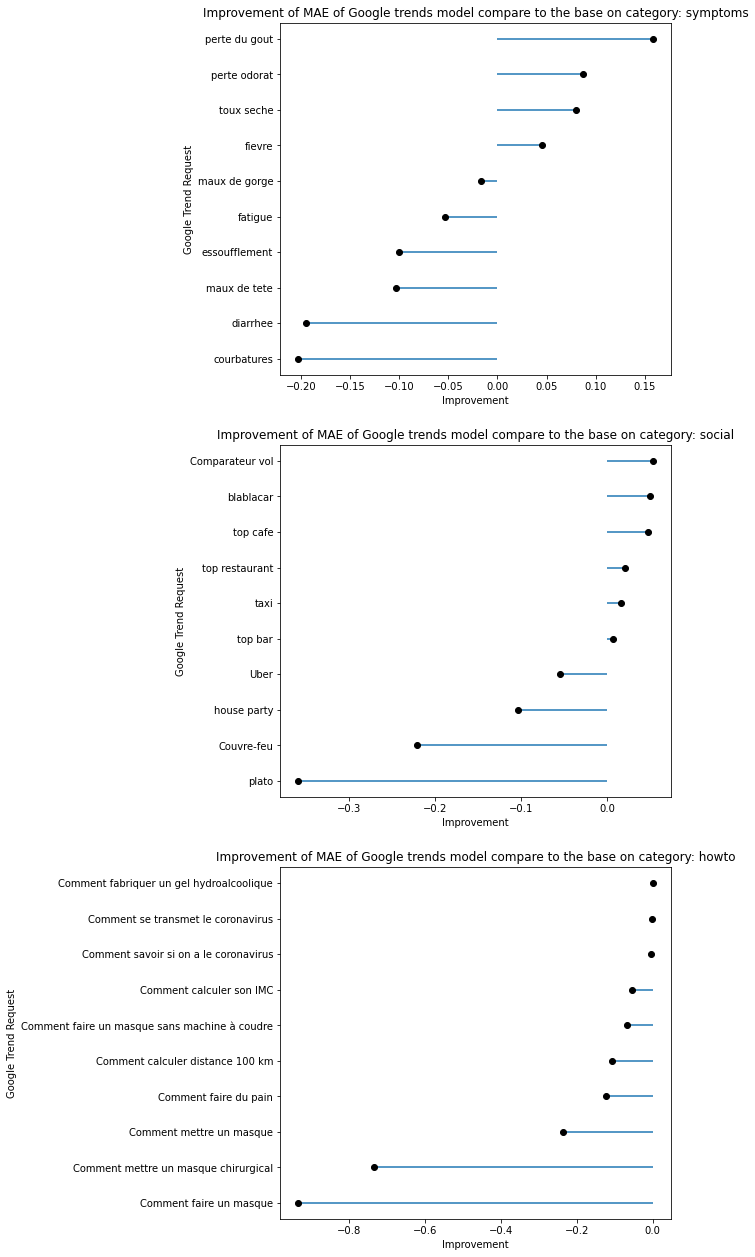

In [89]:
# Compute and plot the improvement that provides each features on the MAE for each category
plot_MAE_improvement([(key, MAE_AR(aggregated_data_fr["deaths"], trends_data[values])) for key, values in key_words.items()])

#### Results : 

Let's analyze the results for each category : 

- **symptoms** : The highest MAE improvement appears when we include the loss of smell in the model, and positive improvement is still visible for all the COVID-19's specific symptoms. This result is interesting : By including the requests related to the most particular COVID symptoms, we improve the forecasting model.
- **social** : For this category, we expected those kind of results : The requests that helps improving the model are the queries that are commom to the two waves. For example, there's a decrease of the queries related to the flight comparator because of lockdown, and this effect is present in the 2 waves. But, if we take the plato query, which was a game who got really popular in the first wave of COVID 19 and totally disappeared in the second one, we get an important deterioration of the MAE. This could mean that the social phenomenas in the two waves are different. However, we would have expected a larger effect for the "The Top cafe" and "Top restaurant" keywords. The smaller oberseved effect could be explained by the fact that the model is still a simple model and doesn"t learn to "anticipate", since these two keywords should have an indicator role before the wave arrives.
- **howto** : Here we observe that most of the features have a negative improvement. That can be interepreted by the fact that these features could help in fitting the first wave, but are not features that can generalize this phenomena, therefore, when we try to predict the second wave we get a worse result than with the base model. That is called overfitting.

## 4. Conclusion

- Through this analysis we figured out that the topic the most related to the evolution of the number of deaths in France was the symptoms and social related activities.
- We have seen that some of the symptoms like the lost of smell or taste are intrinsic features to predict the number of deaths from the COVID-19. Theses features helped reaching an improvement of 15% from the base model.
- Some of the social related activities can help better predict the number of the covid cases, nevertheless, the others were really helpfull to predict the first wave, but less with the second wave. Therefore, we cannot rely on all of the social related features to predict the number of deaths from COVID-19.
- We have seen that including some features from Google Trends in the base model, could help better predict noisy data such as COVID-19 deaths.

## 5. Going Further

To go further, it would be interesting to combine the best features together to get an even higher improvement. After trying on the simple model that we had, not such good results have been found. It would be interesting to try with other models.